In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [18]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs') # rewards
    rates = tf.placeholder(tf.float32, [None], name='rates') # dones
    return states, actions, next_states, targetQs, rates

In [19]:
# Generator/Controller: Generating/prediting the actions
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Input layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        actions_logits = tf.layers.dense(inputs=nl2, units=action_size)
        next_states_logits = tf.layers.dense(inputs=actions_logits, units=state_size, trainable=False)
        return actions_logits, next_states_logits

In [20]:
def discriminator(states, actions, next_states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        h1_fused = tf.concat(axis=1, values=[states, next_states])
        h1 = tf.layers.dense(inputs=h1_fused, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [22]:
def model_loss(state_size, action_size, hidden_size, #x, h, y
               states, actions, next_states, targetQs, rates): # s,a,s',r,d
    actions_logits, next_states_logits = generator(states=states, hidden_size=hidden_size, 
                                                   action_size=action_size, state_size=state_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gloss2 = tf.reduce_mean(tf.square(next_states - next_states_logits))
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, 
                        next_states=next_states_logits)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, 
                        next_states=next_states, reuse=True)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    # dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
    #                                                                 labels=tf.nn.sigmoid(targetQs))) # 0-1
    #glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, gloss2, dloss, dlossQ

In [23]:
def model_opt(g_loss, g_loss2, d_loss, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        g_opt2 = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss2, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)
    return g_opt, g_opt2, d_opt, d_optQ

In [29]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.g_loss2, self.d_loss, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size, # model init parameters
            states=self.states, actions=self.actions, # model input 
            next_states=self.next_states, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.g_opt2, self.d_opt, self.d_optQ = model_opt(g_loss=self.g_loss, g_loss2=self.g_loss2,
                                                                     d_loss=self.d_loss, d_lossQ=self.d_lossQ,
                                                                     g_learning_rate=g_learning_rate, 
                                                                     d_learning_rate=d_learning_rate)

In [30]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [31]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [32]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [33]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [34]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [36]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, gloss2_batch, dloss_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _ = sess.run([model.d_loss, model.d_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.next_states: next_states,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            dlossQ, _ = sess.run([model.d_lossQ, model.d_optQ], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.next_states: next_states,
                                                                             model.targetQs: targetQs, 
                                                                             model.rates: rates})
            gloss2, _ = sess.run([model.g_loss2, model.g_opt2], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.next_states: next_states,
                                                                             model.targetQs: targetQs, 
                                                                             model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.next_states: next_states,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            gloss_batch.append(gloss)
            gloss2_batch.append(gloss2)
            dloss_batch.append(dloss)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'gloss2:{:.4f}'.format(np.mean(gloss2_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 gloss:0.6948 gloss2:0.2189 dloss:0.5838 dlossQ:1.7748 exploreP:0.9979
Episode:1 meanR:19.0000 R:17.0000 rate:0.0340 gloss:0.7008 gloss2:0.2170 dloss:0.5881 dlossQ:1.7625 exploreP:0.9962
Episode:2 meanR:19.0000 R:19.0000 rate:0.0380 gloss:0.6994 gloss2:0.2089 dloss:0.5906 dlossQ:1.7653 exploreP:0.9944
Episode:3 meanR:20.5000 R:25.0000 rate:0.0500 gloss:0.6931 gloss2:0.2014 dloss:0.5930 dlossQ:1.7390 exploreP:0.9919
Episode:4 meanR:20.8000 R:22.0000 rate:0.0440 gloss:0.6880 gloss2:0.1843 dloss:0.5882 dlossQ:1.7320 exploreP:0.9898
Episode:5 meanR:19.0000 R:10.0000 rate:0.0200 gloss:0.7076 gloss2:0.2593 dloss:0.5975 dlossQ:1.7563 exploreP:0.9888
Episode:6 meanR:17.8571 R:11.0000 rate:0.0220 gloss:0.6905 gloss2:0.1580 dloss:0.5872 dlossQ:1.7236 exploreP:0.9877
Episode:7 meanR:17.7500 R:17.0000 rate:0.0340 gloss:0.6984 gloss2:0.2000 dloss:0.5867 dlossQ:1.7852 exploreP:0.9860
Episode:8 meanR:18.2222 R:22.0000 rate:0.0440 gloss:0.6982 gloss2:0.2192

Episode:71 meanR:27.6944 R:20.0000 rate:0.0400 gloss:0.6800 gloss2:0.1347 dloss:0.5862 dlossQ:1.7497 exploreP:0.8210
Episode:72 meanR:27.4932 R:13.0000 rate:0.0260 gloss:0.6703 gloss2:0.1996 dloss:0.5883 dlossQ:1.6688 exploreP:0.8200
Episode:73 meanR:27.5000 R:28.0000 rate:0.0560 gloss:0.6802 gloss2:0.1467 dloss:0.5878 dlossQ:1.7349 exploreP:0.8177
Episode:74 meanR:27.9467 R:61.0000 rate:0.1220 gloss:0.6789 gloss2:0.1492 dloss:0.5928 dlossQ:1.6990 exploreP:0.8128
Episode:75 meanR:28.0263 R:34.0000 rate:0.0680 gloss:0.6784 gloss2:0.1370 dloss:0.5898 dlossQ:1.7069 exploreP:0.8101
Episode:76 meanR:28.1169 R:35.0000 rate:0.0700 gloss:0.6815 gloss2:0.1748 dloss:0.5866 dlossQ:1.7347 exploreP:0.8073
Episode:77 meanR:28.2564 R:39.0000 rate:0.0780 gloss:0.6796 gloss2:0.1465 dloss:0.5872 dlossQ:1.7239 exploreP:0.8042
Episode:78 meanR:28.2658 R:29.0000 rate:0.0580 gloss:0.6744 gloss2:0.1494 dloss:0.5887 dlossQ:1.6948 exploreP:0.8019
Episode:79 meanR:28.4250 R:41.0000 rate:0.0820 gloss:0.6671 glos

Episode:141 meanR:33.8600 R:51.0000 rate:0.1020 gloss:0.6770 gloss2:0.1341 dloss:0.5884 dlossQ:1.7050 exploreP:0.6470
Episode:142 meanR:34.3200 R:67.0000 rate:0.1340 gloss:0.6737 gloss2:0.1398 dloss:0.5906 dlossQ:1.6948 exploreP:0.6427
Episode:143 meanR:34.7900 R:61.0000 rate:0.1220 gloss:0.6756 gloss2:0.1464 dloss:0.5875 dlossQ:1.7181 exploreP:0.6389
Episode:144 meanR:34.9700 R:57.0000 rate:0.1140 gloss:0.6667 gloss2:0.1373 dloss:0.5842 dlossQ:1.6949 exploreP:0.6353
Episode:145 meanR:34.4000 R:27.0000 rate:0.0540 gloss:0.6698 gloss2:0.1295 dloss:0.5889 dlossQ:1.6700 exploreP:0.6336
Episode:146 meanR:34.3200 R:17.0000 rate:0.0340 gloss:0.6834 gloss2:0.1305 dloss:0.5919 dlossQ:1.7004 exploreP:0.6325
Episode:147 meanR:34.3800 R:19.0000 rate:0.0380 gloss:0.6789 gloss2:0.1400 dloss:0.5934 dlossQ:1.7261 exploreP:0.6314
Episode:148 meanR:34.0500 R:20.0000 rate:0.0400 gloss:0.6729 gloss2:0.1283 dloss:0.5908 dlossQ:1.6916 exploreP:0.6301
Episode:149 meanR:34.0400 R:32.0000 rate:0.0640 gloss:0.

Episode:211 meanR:55.9500 R:60.0000 rate:0.1200 gloss:0.6872 gloss2:0.1416 dloss:0.5985 dlossQ:1.6743 exploreP:0.4153
Episode:212 meanR:56.4500 R:78.0000 rate:0.1560 gloss:0.6874 gloss2:0.1350 dloss:0.6023 dlossQ:1.6566 exploreP:0.4121
Episode:213 meanR:56.5700 R:30.0000 rate:0.0600 gloss:0.6797 gloss2:0.1417 dloss:0.6046 dlossQ:1.6465 exploreP:0.4109
Episode:214 meanR:57.8800 R:144.0000 rate:0.2880 gloss:0.6863 gloss2:0.1423 dloss:0.6043 dlossQ:1.6522 exploreP:0.4052
Episode:215 meanR:57.8000 R:23.0000 rate:0.0460 gloss:0.6781 gloss2:0.1293 dloss:0.6004 dlossQ:1.6184 exploreP:0.4043
Episode:216 meanR:62.0000 R:447.0000 rate:0.8940 gloss:0.6904 gloss2:0.1351 dloss:0.6095 dlossQ:1.6354 exploreP:0.3871
Episode:217 meanR:63.1400 R:126.0000 rate:0.2520 gloss:0.6935 gloss2:0.1357 dloss:0.6122 dlossQ:1.6292 exploreP:0.3823
Episode:218 meanR:64.4000 R:142.0000 rate:0.2840 gloss:0.6923 gloss2:0.1367 dloss:0.6146 dlossQ:1.6187 exploreP:0.3771
Episode:219 meanR:65.3500 R:131.0000 rate:0.2620 glo

Episode:280 meanR:116.8500 R:221.0000 rate:0.4420 gloss:0.7956 gloss2:0.1348 dloss:0.7157 dlossQ:1.2197 exploreP:0.1711
Episode:281 meanR:118.9100 R:225.0000 rate:0.4500 gloss:0.7987 gloss2:0.1409 dloss:0.7193 dlossQ:1.2052 exploreP:0.1675
Episode:282 meanR:122.5900 R:405.0000 rate:0.8100 gloss:0.8057 gloss2:0.1433 dloss:0.7262 dlossQ:1.1806 exploreP:0.1613
Episode:283 meanR:125.7400 R:351.0000 rate:0.7020 gloss:0.8128 gloss2:0.1408 dloss:0.7329 dlossQ:1.1665 exploreP:0.1560
Episode:284 meanR:127.2400 R:262.0000 rate:0.5240 gloss:0.8145 gloss2:0.1343 dloss:0.7335 dlossQ:1.1448 exploreP:0.1523
Episode:285 meanR:128.9200 R:235.0000 rate:0.4700 gloss:0.8223 gloss2:0.1475 dloss:0.7400 dlossQ:1.1249 exploreP:0.1490
Episode:286 meanR:128.4000 R:65.0000 rate:0.1300 gloss:0.8199 gloss2:0.1450 dloss:0.7417 dlossQ:1.0917 exploreP:0.1481
Episode:287 meanR:129.7600 R:261.0000 rate:0.5220 gloss:0.8239 gloss2:0.1308 dloss:0.7524 dlossQ:1.0845 exploreP:0.1445
Episode:288 meanR:129.7200 R:28.0000 rate

Episode:349 meanR:225.6300 R:316.0000 rate:0.6320 gloss:1.3061 gloss2:0.1346 dloss:1.2059 dlossQ:0.3572 exploreP:0.0345
Episode:350 meanR:225.8800 R:303.0000 rate:0.6060 gloss:1.3171 gloss2:0.1309 dloss:1.1913 dlossQ:0.3476 exploreP:0.0338
Episode:351 meanR:227.0500 R:293.0000 rate:0.5860 gloss:1.3619 gloss2:0.1469 dloss:1.2617 dlossQ:0.3707 exploreP:0.0331
Episode:352 meanR:228.1500 R:274.0000 rate:0.5480 gloss:1.3625 gloss2:0.1301 dloss:1.2721 dlossQ:0.3583 exploreP:0.0325
Episode:353 meanR:228.9400 R:146.0000 rate:0.2920 gloss:1.3388 gloss2:0.1284 dloss:1.1757 dlossQ:0.3290 exploreP:0.0322
Episode:354 meanR:228.9800 R:185.0000 rate:0.3700 gloss:1.3670 gloss2:0.1431 dloss:1.2831 dlossQ:0.3470 exploreP:0.0317
Episode:355 meanR:231.4100 R:308.0000 rate:0.6160 gloss:1.3594 gloss2:0.1416 dloss:1.2356 dlossQ:0.3314 exploreP:0.0311
Episode:356 meanR:232.3000 R:178.0000 rate:0.3560 gloss:1.3666 gloss2:0.1376 dloss:1.2904 dlossQ:0.3241 exploreP:0.0307
Episode:357 meanR:234.8400 R:322.0000 ra

Episode:418 meanR:287.6200 R:254.0000 rate:0.5080 gloss:1.8237 gloss2:0.1460 dloss:1.5822 dlossQ:0.2326 exploreP:0.0133
Episode:419 meanR:288.7900 R:275.0000 rate:0.5500 gloss:1.8215 gloss2:0.1425 dloss:1.4696 dlossQ:0.2326 exploreP:0.0132
Episode:420 meanR:287.1400 R:187.0000 rate:0.3740 gloss:1.8763 gloss2:0.1530 dloss:1.5355 dlossQ:0.2622 exploreP:0.0132
Episode:421 meanR:284.6300 R:249.0000 rate:0.4980 gloss:1.8629 gloss2:0.1705 dloss:1.5831 dlossQ:0.2567 exploreP:0.0131
Episode:422 meanR:284.3700 R:238.0000 rate:0.4760 gloss:1.8481 gloss2:0.1495 dloss:1.4305 dlossQ:0.2406 exploreP:0.0130
Episode:423 meanR:283.8500 R:187.0000 rate:0.3740 gloss:1.8833 gloss2:0.1646 dloss:1.5979 dlossQ:0.2435 exploreP:0.0130
Episode:424 meanR:284.4100 R:197.0000 rate:0.3940 gloss:1.8752 gloss2:0.1577 dloss:1.5594 dlossQ:0.2495 exploreP:0.0129
Episode:425 meanR:284.3500 R:277.0000 rate:0.5540 gloss:1.9064 gloss2:0.1633 dloss:1.6166 dlossQ:0.2611 exploreP:0.0128
Episode:426 meanR:285.0500 R:321.0000 ra

Episode:487 meanR:269.9900 R:204.0000 rate:0.4080 gloss:2.1840 gloss2:0.1840 dloss:1.7183 dlossQ:0.3182 exploreP:0.0105
Episode:488 meanR:271.7800 R:329.0000 rate:0.6580 gloss:2.2112 gloss2:0.1726 dloss:1.6360 dlossQ:0.2953 exploreP:0.0105
Episode:489 meanR:270.9900 R:187.0000 rate:0.3740 gloss:2.2123 gloss2:0.1795 dloss:1.6519 dlossQ:0.3059 exploreP:0.0105
Episode:490 meanR:270.2500 R:188.0000 rate:0.3760 gloss:2.1886 gloss2:0.1701 dloss:1.5981 dlossQ:0.2589 exploreP:0.0105
Episode:491 meanR:269.7900 R:277.0000 rate:0.5540 gloss:2.1786 gloss2:0.1782 dloss:1.5597 dlossQ:0.2687 exploreP:0.0105
Episode:492 meanR:268.8000 R:291.0000 rate:0.5820 gloss:2.2417 gloss2:0.1774 dloss:1.6996 dlossQ:0.2870 exploreP:0.0105
Episode:493 meanR:266.5500 R:187.0000 rate:0.3740 gloss:2.2411 gloss2:0.1750 dloss:1.6284 dlossQ:0.2992 exploreP:0.0105
Episode:494 meanR:266.3500 R:216.0000 rate:0.4320 gloss:2.2445 gloss2:0.1714 dloss:1.6788 dlossQ:0.2678 exploreP:0.0105
Episode:495 meanR:264.4500 R:170.0000 ra

Episode:556 meanR:247.4200 R:306.0000 rate:0.6120 gloss:2.3513 gloss2:0.2146 dloss:1.5765 dlossQ:0.3398 exploreP:0.0101
Episode:557 meanR:247.3700 R:150.0000 rate:0.3000 gloss:2.4816 gloss2:0.2336 dloss:1.8822 dlossQ:0.3796 exploreP:0.0101
Episode:558 meanR:246.3700 R:216.0000 rate:0.4320 gloss:2.3130 gloss2:0.2050 dloss:1.5953 dlossQ:0.3671 exploreP:0.0101
Episode:559 meanR:245.3200 R:172.0000 rate:0.3440 gloss:2.3422 gloss2:0.2211 dloss:1.6707 dlossQ:0.3593 exploreP:0.0101
Episode:560 meanR:243.8300 R:163.0000 rate:0.3260 gloss:2.3327 gloss2:0.2206 dloss:1.5556 dlossQ:0.3494 exploreP:0.0101
Episode:561 meanR:243.5100 R:249.0000 rate:0.4980 gloss:2.3660 gloss2:0.2334 dloss:1.6649 dlossQ:0.3908 exploreP:0.0101
Episode:562 meanR:244.2900 R:324.0000 rate:0.6480 gloss:2.3540 gloss2:0.2144 dloss:1.6439 dlossQ:0.4359 exploreP:0.0101
Episode:563 meanR:244.1800 R:261.0000 rate:0.5220 gloss:2.3236 gloss2:0.2257 dloss:1.5638 dlossQ:0.3821 exploreP:0.0101
Episode:564 meanR:242.2600 R:68.0000 rat

Episode:625 meanR:210.3300 R:193.0000 rate:0.3860 gloss:1.3614 gloss2:0.3078 dloss:0.9600 dlossQ:0.4181 exploreP:0.0100
Episode:626 meanR:211.5300 R:267.0000 rate:0.5340 gloss:1.3748 gloss2:0.3110 dloss:0.9873 dlossQ:0.4366 exploreP:0.0100
Episode:627 meanR:210.0400 R:144.0000 rate:0.2880 gloss:1.4123 gloss2:0.3014 dloss:1.0110 dlossQ:0.4553 exploreP:0.0100
Episode:628 meanR:208.8100 R:192.0000 rate:0.3840 gloss:1.3180 gloss2:0.3068 dloss:0.9840 dlossQ:0.4090 exploreP:0.0100
Episode:629 meanR:207.9800 R:163.0000 rate:0.3260 gloss:1.3395 gloss2:0.3157 dloss:0.9047 dlossQ:0.4340 exploreP:0.0100
Episode:630 meanR:207.5000 R:226.0000 rate:0.4520 gloss:1.3482 gloss2:0.3128 dloss:0.9736 dlossQ:0.4116 exploreP:0.0100
Episode:631 meanR:205.9200 R:80.0000 rate:0.1600 gloss:1.3051 gloss2:0.2954 dloss:0.9684 dlossQ:0.4138 exploreP:0.0100
Episode:632 meanR:204.5600 R:110.0000 rate:0.2200 gloss:1.3074 gloss2:0.3050 dloss:0.9508 dlossQ:0.3821 exploreP:0.0100
Episode:633 meanR:206.3800 R:258.0000 rat

Episode:694 meanR:217.4900 R:186.0000 rate:0.3720 gloss:1.2342 gloss2:0.5195 dloss:1.1365 dlossQ:0.2875 exploreP:0.0100
Episode:695 meanR:219.9400 R:342.0000 rate:0.6840 gloss:1.2323 gloss2:0.5150 dloss:1.1282 dlossQ:0.2611 exploreP:0.0100
Episode:696 meanR:220.4600 R:255.0000 rate:0.5100 gloss:1.2610 gloss2:0.5572 dloss:1.1223 dlossQ:0.3126 exploreP:0.0100
Episode:697 meanR:220.1600 R:186.0000 rate:0.3720 gloss:1.2579 gloss2:0.5936 dloss:1.0847 dlossQ:0.3240 exploreP:0.0100
Episode:698 meanR:219.3700 R:154.0000 rate:0.3080 gloss:1.2232 gloss2:0.5558 dloss:1.1780 dlossQ:0.2755 exploreP:0.0100
Episode:699 meanR:220.4000 R:259.0000 rate:0.5180 gloss:1.2263 gloss2:0.5752 dloss:1.1063 dlossQ:0.2924 exploreP:0.0100
Episode:700 meanR:220.2900 R:281.0000 rate:0.5620 gloss:1.2205 gloss2:0.6034 dloss:1.1256 dlossQ:0.3046 exploreP:0.0100
Episode:701 meanR:220.7400 R:283.0000 rate:0.5660 gloss:1.1997 gloss2:0.6403 dloss:1.1350 dlossQ:0.3616 exploreP:0.0100
Episode:702 meanR:220.4800 R:145.0000 ra

Episode:763 meanR:236.9800 R:153.0000 rate:0.3060 gloss:1.1634 gloss2:1.1179 dloss:1.2639 dlossQ:1.1131 exploreP:0.0100
Episode:764 meanR:236.7900 R:167.0000 rate:0.3340 gloss:1.1740 gloss2:1.2187 dloss:1.3308 dlossQ:1.2512 exploreP:0.0100
Episode:765 meanR:235.5600 R:155.0000 rate:0.3100 gloss:1.1577 gloss2:1.1887 dloss:1.3966 dlossQ:1.3142 exploreP:0.0100
Episode:766 meanR:234.9400 R:186.0000 rate:0.3720 gloss:1.1892 gloss2:1.1140 dloss:1.3457 dlossQ:1.3195 exploreP:0.0100
Episode:767 meanR:235.3600 R:285.0000 rate:0.5700 gloss:1.1538 gloss2:1.1593 dloss:1.4384 dlossQ:1.3670 exploreP:0.0100
Episode:768 meanR:236.0900 R:286.0000 rate:0.5720 gloss:1.1599 gloss2:1.2068 dloss:1.3101 dlossQ:1.4346 exploreP:0.0100
Episode:769 meanR:236.6300 R:323.0000 rate:0.6460 gloss:1.1922 gloss2:1.1927 dloss:1.3830 dlossQ:1.5900 exploreP:0.0100
Episode:770 meanR:237.2500 R:260.0000 rate:0.5200 gloss:1.1926 gloss2:1.1454 dloss:1.4340 dlossQ:1.6174 exploreP:0.0100
Episode:771 meanR:236.3600 R:199.0000 ra

Episode:832 meanR:221.2400 R:194.0000 rate:0.3880 gloss:1.3493 gloss2:0.6021 dloss:1.3977 dlossQ:1.4208 exploreP:0.0100
Episode:833 meanR:221.2300 R:166.0000 rate:0.3320 gloss:1.3605 gloss2:0.6001 dloss:1.4001 dlossQ:1.4265 exploreP:0.0100
Episode:834 meanR:220.4900 R:159.0000 rate:0.3180 gloss:1.3696 gloss2:0.5987 dloss:1.4018 dlossQ:1.4439 exploreP:0.0100
Episode:835 meanR:220.4700 R:151.0000 rate:0.3020 gloss:1.3546 gloss2:0.5845 dloss:1.4164 dlossQ:1.4234 exploreP:0.0100
Episode:836 meanR:220.7500 R:276.0000 rate:0.5520 gloss:1.3640 gloss2:0.5775 dloss:1.3531 dlossQ:1.3246 exploreP:0.0100
Episode:837 meanR:221.3300 R:211.0000 rate:0.4220 gloss:1.3480 gloss2:0.5811 dloss:1.3703 dlossQ:1.4162 exploreP:0.0100
Episode:838 meanR:221.7800 R:234.0000 rate:0.4680 gloss:1.3738 gloss2:0.5821 dloss:1.3917 dlossQ:1.4050 exploreP:0.0100
Episode:839 meanR:220.6800 R:170.0000 rate:0.3400 gloss:1.3771 gloss2:0.5751 dloss:1.3986 dlossQ:1.2544 exploreP:0.0100
Episode:840 meanR:220.1800 R:205.0000 ra

Episode:901 meanR:199.6300 R:328.0000 rate:0.6560 gloss:1.3647 gloss2:0.5934 dloss:1.2021 dlossQ:3.0780 exploreP:0.0100
Episode:902 meanR:199.1100 R:184.0000 rate:0.3680 gloss:1.3753 gloss2:0.5666 dloss:1.2348 dlossQ:3.0663 exploreP:0.0100
Episode:903 meanR:199.2100 R:178.0000 rate:0.3560 gloss:1.3680 gloss2:0.5802 dloss:1.2208 dlossQ:3.1342 exploreP:0.0100
Episode:904 meanR:199.1500 R:235.0000 rate:0.4700 gloss:1.3749 gloss2:0.5721 dloss:1.2266 dlossQ:3.1158 exploreP:0.0100
Episode:905 meanR:197.6100 R:161.0000 rate:0.3220 gloss:1.3770 gloss2:0.5670 dloss:1.2171 dlossQ:3.1018 exploreP:0.0100
Episode:906 meanR:196.1000 R:139.0000 rate:0.2780 gloss:1.3675 gloss2:0.5865 dloss:1.1420 dlossQ:3.2985 exploreP:0.0100
Episode:907 meanR:196.4400 R:184.0000 rate:0.3680 gloss:1.3489 gloss2:0.5667 dloss:1.2153 dlossQ:2.8396 exploreP:0.0100
Episode:908 meanR:197.4400 R:274.0000 rate:0.5480 gloss:1.3478 gloss2:0.5701 dloss:1.2225 dlossQ:3.2207 exploreP:0.0100
Episode:909 meanR:197.2500 R:148.0000 ra

Episode:970 meanR:198.3300 R:251.0000 rate:0.5020 gloss:1.2241 gloss2:0.8122 dloss:1.2425 dlossQ:3.1653 exploreP:0.0100
Episode:971 meanR:199.4000 R:248.0000 rate:0.4960 gloss:1.2073 gloss2:0.8769 dloss:1.1876 dlossQ:3.2201 exploreP:0.0100
Episode:972 meanR:199.2600 R:158.0000 rate:0.3160 gloss:1.1934 gloss2:0.9159 dloss:1.1983 dlossQ:3.0562 exploreP:0.0100
Episode:973 meanR:198.6200 R:187.0000 rate:0.3740 gloss:1.2284 gloss2:0.8906 dloss:1.2676 dlossQ:3.5252 exploreP:0.0100
Episode:974 meanR:199.3600 R:235.0000 rate:0.4700 gloss:1.2134 gloss2:0.9075 dloss:1.2232 dlossQ:3.1635 exploreP:0.0100
Episode:975 meanR:199.3000 R:169.0000 rate:0.3380 gloss:1.2299 gloss2:0.9232 dloss:1.2745 dlossQ:3.4462 exploreP:0.0100
Episode:976 meanR:196.9600 R:43.0000 rate:0.0860 gloss:1.2285 gloss2:1.0074 dloss:1.2379 dlossQ:3.6745 exploreP:0.0100
Episode:977 meanR:197.2500 R:182.0000 rate:0.3640 gloss:1.2014 gloss2:0.9333 dloss:1.1987 dlossQ:3.2271 exploreP:0.0100
Episode:978 meanR:197.4800 R:207.0000 rat

Episode:1039 meanR:196.2700 R:80.0000 rate:0.1600 gloss:1.0724 gloss2:1.1243 dloss:1.1345 dlossQ:3.2336 exploreP:0.0100
Episode:1040 meanR:196.1400 R:143.0000 rate:0.2860 gloss:1.0884 gloss2:1.1062 dloss:1.1294 dlossQ:2.7922 exploreP:0.0100
Episode:1041 meanR:193.9300 R:74.0000 rate:0.1480 gloss:1.1006 gloss2:1.1461 dloss:1.1627 dlossQ:2.9850 exploreP:0.0100
Episode:1042 meanR:191.9800 R:78.0000 rate:0.1560 gloss:1.0964 gloss2:1.3110 dloss:1.1735 dlossQ:3.6381 exploreP:0.0100
Episode:1043 meanR:191.9500 R:147.0000 rate:0.2940 gloss:1.0664 gloss2:1.0604 dloss:1.1155 dlossQ:2.7598 exploreP:0.0100
Episode:1044 meanR:191.6100 R:206.0000 rate:0.4120 gloss:1.0659 gloss2:1.0996 dloss:1.0972 dlossQ:3.0818 exploreP:0.0100
Episode:1045 meanR:191.0700 R:176.0000 rate:0.3520 gloss:1.0862 gloss2:1.1541 dloss:1.1116 dlossQ:3.2253 exploreP:0.0100
Episode:1046 meanR:190.0200 R:74.0000 rate:0.1480 gloss:1.0713 gloss2:1.1935 dloss:1.0792 dlossQ:3.5483 exploreP:0.0100
Episode:1047 meanR:188.9300 R:79.000

Episode:1107 meanR:206.4800 R:222.0000 rate:0.4440 gloss:1.1744 gloss2:2.7530 dloss:1.1408 dlossQ:30.3114 exploreP:0.0100
Episode:1108 meanR:206.9300 R:225.0000 rate:0.4500 gloss:1.1811 gloss2:2.7396 dloss:1.1743 dlossQ:32.2053 exploreP:0.0100
Episode:1109 meanR:206.8000 R:153.0000 rate:0.3060 gloss:1.1950 gloss2:2.3573 dloss:1.1154 dlossQ:30.4458 exploreP:0.0100
Episode:1110 meanR:207.5300 R:263.0000 rate:0.5260 gloss:1.2006 gloss2:2.0815 dloss:1.1003 dlossQ:31.5085 exploreP:0.0100
Episode:1111 meanR:208.2500 R:265.0000 rate:0.5300 gloss:1.1933 gloss2:2.3651 dloss:1.1073 dlossQ:36.5610 exploreP:0.0100
Episode:1112 meanR:208.2900 R:191.0000 rate:0.3820 gloss:1.2534 gloss2:2.1523 dloss:1.1096 dlossQ:42.0867 exploreP:0.0100
Episode:1113 meanR:209.1400 R:269.0000 rate:0.5380 gloss:1.2612 gloss2:2.3331 dloss:1.1411 dlossQ:42.0567 exploreP:0.0100
Episode:1114 meanR:209.8700 R:232.0000 rate:0.4640 gloss:1.2621 gloss2:1.6928 dloss:1.0837 dlossQ:37.0118 exploreP:0.0100
Episode:1115 meanR:209.8

Episode:1175 meanR:243.4900 R:288.0000 rate:0.5760 gloss:0.9347 gloss2:0.6604 dloss:0.7747 dlossQ:8.2084 exploreP:0.0100
Episode:1176 meanR:245.6200 R:446.0000 rate:0.8920 gloss:0.9589 gloss2:0.6805 dloss:0.7832 dlossQ:9.5357 exploreP:0.0100
Episode:1177 meanR:245.3300 R:208.0000 rate:0.4160 gloss:0.8975 gloss2:0.6048 dloss:0.7741 dlossQ:7.7319 exploreP:0.0100
Episode:1178 meanR:245.6400 R:239.0000 rate:0.4780 gloss:0.9511 gloss2:0.6920 dloss:0.7859 dlossQ:9.4670 exploreP:0.0100
Episode:1179 meanR:244.9200 R:181.0000 rate:0.3620 gloss:0.9256 gloss2:0.6422 dloss:0.7856 dlossQ:8.9895 exploreP:0.0100
Episode:1180 meanR:245.4400 R:226.0000 rate:0.4520 gloss:0.9560 gloss2:0.6622 dloss:0.7835 dlossQ:9.5088 exploreP:0.0100
Episode:1181 meanR:246.7500 R:380.0000 rate:0.7600 gloss:0.9312 gloss2:0.6362 dloss:0.7890 dlossQ:9.1975 exploreP:0.0100
Episode:1182 meanR:246.3100 R:121.0000 rate:0.2420 gloss:0.9994 gloss2:0.9026 dloss:0.8113 dlossQ:20.2522 exploreP:0.0100
Episode:1183 meanR:247.6200 R:2

Episode:1243 meanR:234.0900 R:182.0000 rate:0.3640 gloss:0.8796 gloss2:0.8549 dloss:0.8557 dlossQ:5.6572 exploreP:0.0100
Episode:1244 meanR:232.1000 R:192.0000 rate:0.3840 gloss:0.8885 gloss2:0.8926 dloss:0.8388 dlossQ:6.4974 exploreP:0.0100
Episode:1245 meanR:231.6100 R:184.0000 rate:0.3680 gloss:0.8940 gloss2:0.8526 dloss:0.8525 dlossQ:5.6628 exploreP:0.0100
Episode:1246 meanR:230.3900 R:163.0000 rate:0.3260 gloss:0.8807 gloss2:0.8360 dloss:0.8497 dlossQ:5.2133 exploreP:0.0100
Episode:1247 meanR:229.5200 R:163.0000 rate:0.3260 gloss:0.8560 gloss2:0.7626 dloss:0.8308 dlossQ:4.5259 exploreP:0.0100
Episode:1248 meanR:227.3600 R:111.0000 rate:0.2220 gloss:0.8777 gloss2:0.7880 dloss:0.8437 dlossQ:4.9388 exploreP:0.0100
Episode:1249 meanR:225.5500 R:169.0000 rate:0.3380 gloss:0.9137 gloss2:0.9196 dloss:0.8526 dlossQ:6.6943 exploreP:0.0100
Episode:1250 meanR:225.0000 R:177.0000 rate:0.3540 gloss:0.8749 gloss2:0.8790 dloss:0.8119 dlossQ:6.1453 exploreP:0.0100
Episode:1251 meanR:224.1200 R:17

Episode:1311 meanR:177.1700 R:195.0000 rate:0.3900 gloss:0.7070 gloss2:0.9208 dloss:0.8200 dlossQ:6.8089 exploreP:0.0100
Episode:1312 meanR:177.5200 R:151.0000 rate:0.3020 gloss:0.6881 gloss2:0.8947 dloss:0.8115 dlossQ:7.8680 exploreP:0.0100
Episode:1313 meanR:177.1400 R:147.0000 rate:0.2940 gloss:0.3255 gloss2:1.2580 dloss:0.7698 dlossQ:18.8807 exploreP:0.0100
Episode:1314 meanR:176.5600 R:140.0000 rate:0.2800 gloss:0.6926 gloss2:0.8041 dloss:0.7907 dlossQ:3.9799 exploreP:0.0100
Episode:1315 meanR:176.1900 R:145.0000 rate:0.2900 gloss:0.7004 gloss2:0.7584 dloss:0.8106 dlossQ:4.3961 exploreP:0.0100
Episode:1316 meanR:174.8700 R:120.0000 rate:0.2400 gloss:0.6889 gloss2:0.7786 dloss:0.7867 dlossQ:5.5117 exploreP:0.0100
Episode:1317 meanR:175.3200 R:160.0000 rate:0.3200 gloss:0.6788 gloss2:0.8460 dloss:0.7912 dlossQ:6.8498 exploreP:0.0100
Episode:1318 meanR:173.7200 R:113.0000 rate:0.2260 gloss:0.6630 gloss2:0.7614 dloss:0.7892 dlossQ:8.0813 exploreP:0.0100
Episode:1319 meanR:172.9800 R:1

Episode:1379 meanR:158.9300 R:119.0000 rate:0.2380 gloss:0.4189 gloss2:0.6634 dloss:0.7222 dlossQ:16.4347 exploreP:0.0100
Episode:1380 meanR:158.7500 R:111.0000 rate:0.2220 gloss:0.3376 gloss2:0.8341 dloss:0.7119 dlossQ:25.3022 exploreP:0.0100
Episode:1381 meanR:158.4900 R:129.0000 rate:0.2580 gloss:0.4207 gloss2:0.6007 dloss:0.7229 dlossQ:11.7832 exploreP:0.0100
Episode:1382 meanR:157.7500 R:126.0000 rate:0.2520 gloss:0.4059 gloss2:0.6380 dloss:0.7144 dlossQ:18.3886 exploreP:0.0100
Episode:1383 meanR:156.9900 R:126.0000 rate:0.2520 gloss:0.4064 gloss2:0.6504 dloss:0.7200 dlossQ:20.5047 exploreP:0.0100
Episode:1384 meanR:157.2600 R:159.0000 rate:0.3180 gloss:0.4245 gloss2:0.6031 dloss:0.7189 dlossQ:11.6360 exploreP:0.0100
Episode:1385 meanR:157.2000 R:192.0000 rate:0.3840 gloss:0.4159 gloss2:0.6601 dloss:0.7293 dlossQ:19.8725 exploreP:0.0100
Episode:1386 meanR:156.5300 R:175.0000 rate:0.3500 gloss:0.4006 gloss2:0.6563 dloss:0.7257 dlossQ:23.2711 exploreP:0.0100
Episode:1387 meanR:156.1

Episode:1447 meanR:148.9600 R:148.0000 rate:0.2960 gloss:0.2221 gloss2:0.4790 dloss:0.7054 dlossQ:1.3747 exploreP:0.0100
Episode:1448 meanR:148.5800 R:152.0000 rate:0.3040 gloss:0.2280 gloss2:0.4814 dloss:0.7011 dlossQ:0.6159 exploreP:0.0100
Episode:1449 meanR:148.6200 R:188.0000 rate:0.3760 gloss:0.2299 gloss2:0.5253 dloss:0.7044 dlossQ:1.8710 exploreP:0.0100
Episode:1450 meanR:148.8000 R:167.0000 rate:0.3340 gloss:0.2351 gloss2:0.5075 dloss:0.6978 dlossQ:1.7782 exploreP:0.0100
Episode:1451 meanR:148.8100 R:150.0000 rate:0.3000 gloss:0.2432 gloss2:0.5564 dloss:0.7063 dlossQ:1.2749 exploreP:0.0100
Episode:1452 meanR:148.6300 R:193.0000 rate:0.3860 gloss:0.2287 gloss2:0.5899 dloss:0.6997 dlossQ:1.0298 exploreP:0.0100
Episode:1453 meanR:147.7500 R:108.0000 rate:0.2160 gloss:0.2474 gloss2:0.5688 dloss:0.7062 dlossQ:0.6850 exploreP:0.0100
Episode:1454 meanR:148.3900 R:218.0000 rate:0.4360 gloss:0.2338 gloss2:0.5539 dloss:0.7083 dlossQ:0.6622 exploreP:0.0100
Episode:1455 meanR:148.4300 R:23

Episode:1515 meanR:162.1000 R:142.0000 rate:0.2840 gloss:0.2352 gloss2:0.4540 dloss:0.7223 dlossQ:1.5436 exploreP:0.0100
Episode:1516 meanR:162.7600 R:187.0000 rate:0.3740 gloss:0.2484 gloss2:0.4273 dloss:0.7184 dlossQ:1.3653 exploreP:0.0100
Episode:1517 meanR:162.8600 R:120.0000 rate:0.2400 gloss:0.2437 gloss2:0.4340 dloss:0.7208 dlossQ:1.6774 exploreP:0.0100
Episode:1518 meanR:163.0500 R:140.0000 rate:0.2800 gloss:0.3109 gloss2:0.4979 dloss:0.7204 dlossQ:1.9699 exploreP:0.0100
Episode:1519 meanR:164.1800 R:238.0000 rate:0.4760 gloss:0.2921 gloss2:0.4418 dloss:0.7258 dlossQ:1.4132 exploreP:0.0100
Episode:1520 meanR:165.3300 R:234.0000 rate:0.4680 gloss:0.2778 gloss2:0.4210 dloss:0.7202 dlossQ:1.5615 exploreP:0.0100
Episode:1521 meanR:165.5900 R:120.0000 rate:0.2400 gloss:0.3028 gloss2:0.4381 dloss:0.7179 dlossQ:1.3661 exploreP:0.0100
Episode:1522 meanR:165.4500 R:144.0000 rate:0.2880 gloss:0.2981 gloss2:0.4315 dloss:0.7214 dlossQ:1.1300 exploreP:0.0100
Episode:1523 meanR:165.7000 R:12

Episode:1583 meanR:161.1500 R:124.0000 rate:0.2480 gloss:0.3368 gloss2:0.7393 dloss:0.7287 dlossQ:7.9623 exploreP:0.0100
Episode:1584 meanR:160.8100 R:120.0000 rate:0.2400 gloss:0.3239 gloss2:0.7580 dloss:0.7347 dlossQ:5.3562 exploreP:0.0100
Episode:1585 meanR:159.2500 R:136.0000 rate:0.2720 gloss:0.3355 gloss2:0.8134 dloss:0.7324 dlossQ:8.7902 exploreP:0.0100
Episode:1586 meanR:158.9100 R:117.0000 rate:0.2340 gloss:0.3429 gloss2:0.8647 dloss:0.7274 dlossQ:9.4515 exploreP:0.0100
Episode:1587 meanR:158.5100 R:171.0000 rate:0.3420 gloss:0.3013 gloss2:1.2512 dloss:0.7352 dlossQ:16.3666 exploreP:0.0100
Episode:1588 meanR:158.1300 R:116.0000 rate:0.2320 gloss:0.3439 gloss2:0.8826 dloss:0.7355 dlossQ:9.9246 exploreP:0.0100
Episode:1589 meanR:157.3200 R:148.0000 rate:0.2960 gloss:0.3471 gloss2:0.6499 dloss:0.7420 dlossQ:5.1975 exploreP:0.0100
Episode:1590 meanR:156.6700 R:142.0000 rate:0.2840 gloss:0.3297 gloss2:0.7796 dloss:0.7407 dlossQ:8.0290 exploreP:0.0100
Episode:1591 meanR:156.7700 R:1

Episode:1650 meanR:123.9100 R:9.0000 rate:0.0180 gloss:-2125.0459 gloss2:255.6157 dloss:1.4604 dlossQ:18950.0664 exploreP:0.0100
Episode:1651 meanR:122.8100 R:9.0000 rate:0.0180 gloss:-2345.3364 gloss2:275.9297 dloss:1.6202 dlossQ:20824.3574 exploreP:0.0100
Episode:1652 meanR:120.9900 R:9.0000 rate:0.0180 gloss:-2519.6538 gloss2:289.5262 dloss:1.9987 dlossQ:22268.2773 exploreP:0.0100
Episode:1653 meanR:119.2800 R:10.0000 rate:0.0200 gloss:-2516.0137 gloss2:294.2491 dloss:1.4250 dlossQ:23371.9531 exploreP:0.0100
Episode:1654 meanR:118.1200 R:10.0000 rate:0.0200 gloss:-2764.6934 gloss2:311.8860 dloss:1.8549 dlossQ:25520.9727 exploreP:0.0100
Episode:1655 meanR:116.5600 R:10.0000 rate:0.0200 gloss:-2938.8010 gloss2:320.2740 dloss:1.7429 dlossQ:26822.8438 exploreP:0.0100
Episode:1656 meanR:115.6400 R:10.0000 rate:0.0200 gloss:-3014.6965 gloss2:338.6054 dloss:1.6048 dlossQ:28922.2559 exploreP:0.0100
Episode:1657 meanR:114.3500 R:9.0000 rate:0.0180 gloss:-3276.7742 gloss2:355.7086 dloss:1.960

Episode:1714 meanR:29.5000 R:8.0000 rate:0.0160 gloss:-17070.9648 gloss2:1267.9187 dloss:3.9243 dlossQ:236126.9375 exploreP:0.0100
Episode:1715 meanR:27.3200 R:9.0000 rate:0.0180 gloss:-17473.4922 gloss2:1284.2413 dloss:3.2166 dlossQ:241592.4219 exploreP:0.0100
Episode:1716 meanR:25.8000 R:9.0000 rate:0.0180 gloss:-17439.9766 gloss2:1301.7241 dloss:2.8969 dlossQ:244845.9219 exploreP:0.0100
Episode:1717 meanR:24.6300 R:9.0000 rate:0.0180 gloss:-17664.5020 gloss2:1330.4476 dloss:2.8791 dlossQ:248125.5000 exploreP:0.0100
Episode:1718 meanR:23.2000 R:10.0000 rate:0.0200 gloss:-17903.2598 gloss2:1330.5085 dloss:2.7515 dlossQ:256313.7188 exploreP:0.0100
Episode:1719 meanR:21.8400 R:9.0000 rate:0.0180 gloss:-18611.0684 gloss2:1350.6130 dloss:3.5577 dlossQ:262768.1250 exploreP:0.0100
Episode:1720 meanR:19.4000 R:10.0000 rate:0.0200 gloss:-18888.0840 gloss2:1369.7758 dloss:3.6460 dlossQ:267848.3125 exploreP:0.0100
Episode:1721 meanR:18.0700 R:10.0000 rate:0.0200 gloss:-19389.6895 gloss2:1404.83

Episode:1777 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-42809.2344 gloss2:2550.8186 dloss:4.2488 dlossQ:751480.5000 exploreP:0.0100
Episode:1778 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-43305.0703 gloss2:2523.3003 dloss:4.8984 dlossQ:761030.3125 exploreP:0.0100
Episode:1779 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-45279.4219 gloss2:2601.1506 dloss:5.2565 dlossQ:784154.2500 exploreP:0.0100
Episode:1780 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-45008.7852 gloss2:2603.1477 dloss:4.3636 dlossQ:787047.0000 exploreP:0.0100
Episode:1781 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-43592.3516 gloss2:2571.5967 dloss:4.2213 dlossQ:778284.6250 exploreP:0.0100
Episode:1782 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-46602.4414 gloss2:2675.0833 dloss:5.4122 dlossQ:819187.8750 exploreP:0.0100
Episode:1783 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-46383.1641 gloss2:2715.9094 dloss:5.1371 dlossQ:822120.3750 exploreP:0.0100
Episode:1784 meanR:9.4300 R:11.0000 rate:0.0220 gloss:-46314.6289 gloss2:2698.2327 dlo

Episode:1840 meanR:9.4600 R:11.0000 rate:0.0220 gloss:-72867.4922 gloss2:3977.0745 dloss:6.7218 dlossQ:1610490.7500 exploreP:0.0100
Episode:1841 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-71585.2500 gloss2:3948.1128 dloss:5.1856 dlossQ:1606458.6250 exploreP:0.0100
Episode:1842 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-81047.9844 gloss2:3960.0317 dloss:5.1271 dlossQ:1647270.0000 exploreP:0.0100
Episode:1843 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-74260.0156 gloss2:4064.0352 dloss:5.1121 dlossQ:1639043.7500 exploreP:0.0100
Episode:1844 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-83615.6094 gloss2:4006.9473 dloss:6.2351 dlossQ:1695384.0000 exploreP:0.0100
Episode:1845 meanR:9.4700 R:11.0000 rate:0.0220 gloss:-82909.7891 gloss2:4030.9990 dloss:5.2460 dlossQ:1705842.5000 exploreP:0.0100
Episode:1846 meanR:9.4600 R:9.0000 rate:0.0180 gloss:-83810.5391 gloss2:4106.4043 dloss:5.6848 dlossQ:1716793.5000 exploreP:0.0100
Episode:1847 meanR:9.4700 R:10.0000 rate:0.0200 gloss:-81400.8438 gloss2:3925.

Episode:1903 meanR:9.4700 R:10.0000 rate:0.0200 gloss:-119315.7734 gloss2:5456.0459 dloss:7.2952 dlossQ:3142224.2500 exploreP:0.0100
Episode:1904 meanR:9.4600 R:9.0000 rate:0.0180 gloss:-134472.5625 gloss2:5501.1147 dloss:6.4166 dlossQ:3241932.0000 exploreP:0.0100
Episode:1905 meanR:9.4400 R:8.0000 rate:0.0160 gloss:-132032.7812 gloss2:5393.8721 dloss:7.6639 dlossQ:3209575.5000 exploreP:0.0100
Episode:1906 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-136556.4844 gloss2:5672.4175 dloss:5.9874 dlossQ:3269261.5000 exploreP:0.0100
Episode:1907 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-135688.8750 gloss2:5531.8110 dloss:6.3672 dlossQ:3320383.2500 exploreP:0.0100
Episode:1908 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-136343.2656 gloss2:5520.0752 dloss:7.1544 dlossQ:3339367.0000 exploreP:0.0100
Episode:1909 meanR:9.4200 R:8.0000 rate:0.0160 gloss:-137344.1875 gloss2:5594.5625 dloss:6.5831 dlossQ:3371572.5000 exploreP:0.0100
Episode:1910 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-143078.1562 gloss2:5

Episode:1965 meanR:9.4500 R:8.0000 rate:0.0160 gloss:-212744.3438 gloss2:7356.6992 dloss:6.7115 dlossQ:6052568.0000 exploreP:0.0100
Episode:1966 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-213754.9062 gloss2:7542.5537 dloss:6.8521 dlossQ:6122767.5000 exploreP:0.0100
Episode:1967 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-187440.6875 gloss2:7490.6133 dloss:8.0767 dlossQ:6036185.0000 exploreP:0.0100
Episode:1968 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-223518.2500 gloss2:7707.8545 dloss:9.5964 dlossQ:6400967.0000 exploreP:0.0100
Episode:1969 meanR:9.4700 R:9.0000 rate:0.0180 gloss:-196686.8125 gloss2:7802.9790 dloss:6.4183 dlossQ:6205277.5000 exploreP:0.0100
Episode:1970 meanR:9.4600 R:9.0000 rate:0.0180 gloss:-198989.5469 gloss2:7706.7363 dloss:5.6992 dlossQ:6321813.5000 exploreP:0.0100
Episode:1971 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-227506.7500 gloss2:7723.3999 dloss:8.3507 dlossQ:6587044.0000 exploreP:0.0100
Episode:1972 meanR:9.4600 R:9.0000 rate:0.0180 gloss:-224642.5625 gloss2

Episode:2027 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-333370.0000 gloss2:9994.1250 dloss:7.6509 dlossQ:10932591.0000 exploreP:0.0100
Episode:2028 meanR:9.4900 R:10.0000 rate:0.0200 gloss:-331664.1250 gloss2:9983.1826 dloss:8.1410 dlossQ:11167186.0000 exploreP:0.0100
Episode:2029 meanR:9.4800 R:8.0000 rate:0.0160 gloss:-336180.1250 gloss2:9929.8320 dloss:9.6493 dlossQ:11252224.0000 exploreP:0.0100
Episode:2030 meanR:9.5100 R:11.0000 rate:0.0220 gloss:-319907.8125 gloss2:10243.5117 dloss:10.8310 dlossQ:11428676.0000 exploreP:0.0100
Episode:2031 meanR:9.5300 R:10.0000 rate:0.0200 gloss:-339874.5312 gloss2:10044.4043 dloss:9.5999 dlossQ:11409018.0000 exploreP:0.0100
Episode:2032 meanR:9.5300 R:9.0000 rate:0.0180 gloss:-276069.4688 gloss2:10286.4062 dloss:9.3787 dlossQ:11584206.0000 exploreP:0.0100
Episode:2033 meanR:9.5200 R:9.0000 rate:0.0180 gloss:-281302.0000 gloss2:10523.9580 dloss:9.3869 dlossQ:11563648.0000 exploreP:0.0100
Episode:2034 meanR:9.5000 R:8.0000 rate:0.0160 gloss:-345662

Episode:2088 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-464385.6250 gloss2:12281.8496 dloss:10.5967 dlossQ:17701658.0000 exploreP:0.0100
Episode:2089 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-417857.5938 gloss2:12710.5635 dloss:8.3984 dlossQ:17881030.0000 exploreP:0.0100
Episode:2090 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-478175.5000 gloss2:12306.3496 dloss:9.9015 dlossQ:18102748.0000 exploreP:0.0100
Episode:2091 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-474745.0938 gloss2:12303.0244 dloss:9.1512 dlossQ:18220126.0000 exploreP:0.0100
Episode:2092 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-448255.7500 gloss2:12753.4756 dloss:9.9657 dlossQ:18586950.0000 exploreP:0.0100
Episode:2093 meanR:9.4600 R:9.0000 rate:0.0180 gloss:-483116.1562 gloss2:12402.1465 dloss:8.9049 dlossQ:18398684.0000 exploreP:0.0100
Episode:2094 meanR:9.4600 R:9.0000 rate:0.0180 gloss:-349369.6562 gloss2:13629.6904 dloss:6.3041 dlossQ:18857662.0000 exploreP:0.0100
Episode:2095 meanR:9.4700 R:10.0000 rate:0.0200 gloss:-3973

Episode:2149 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-615147.8750 gloss2:14630.2031 dloss:10.6034 dlossQ:26423112.0000 exploreP:0.0100
Episode:2150 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-620641.6875 gloss2:14651.0117 dloss:11.9438 dlossQ:26598886.0000 exploreP:0.0100
Episode:2151 meanR:9.3600 R:8.0000 rate:0.0160 gloss:-623931.0625 gloss2:14587.2920 dloss:9.1935 dlossQ:26472982.0000 exploreP:0.0100
Episode:2152 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-511760.5938 gloss2:15589.7891 dloss:8.5232 dlossQ:27154076.0000 exploreP:0.0100
Episode:2153 meanR:9.3600 R:8.0000 rate:0.0160 gloss:-642386.5000 gloss2:14649.2275 dloss:10.9682 dlossQ:27108014.0000 exploreP:0.0100
Episode:2154 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-573590.0000 gloss2:15121.1934 dloss:9.5716 dlossQ:27208838.0000 exploreP:0.0100
Episode:2155 meanR:9.3700 R:10.0000 rate:0.0200 gloss:-529307.6875 gloss2:15441.0293 dloss:11.1103 dlossQ:27413204.0000 exploreP:0.0100
Episode:2156 meanR:9.3800 R:9.0000 rate:0.0180 gloss:-6

Episode:2210 meanR:9.2800 R:8.0000 rate:0.0160 gloss:-776113.2500 gloss2:16279.4473 dloss:11.6169 dlossQ:35530704.0000 exploreP:0.0100
Episode:2211 meanR:9.2700 R:9.0000 rate:0.0180 gloss:-765932.3125 gloss2:16717.9824 dloss:9.8775 dlossQ:35419256.0000 exploreP:0.0100
Episode:2212 meanR:9.2800 R:11.0000 rate:0.0220 gloss:-770860.7500 gloss2:16761.5176 dloss:9.7482 dlossQ:35664540.0000 exploreP:0.0100
Episode:2213 meanR:9.3000 R:10.0000 rate:0.0200 gloss:-644974.5000 gloss2:18037.8926 dloss:10.9498 dlossQ:37531944.0000 exploreP:0.0100
Episode:2214 meanR:9.3100 R:10.0000 rate:0.0200 gloss:-800078.8750 gloss2:17080.9941 dloss:10.5728 dlossQ:36474024.0000 exploreP:0.0100
Episode:2215 meanR:9.3100 R:10.0000 rate:0.0200 gloss:-785155.1875 gloss2:16674.3945 dloss:10.6535 dlossQ:36604912.0000 exploreP:0.0100
Episode:2216 meanR:9.3000 R:10.0000 rate:0.0200 gloss:-773679.3125 gloss2:16466.0977 dloss:11.3454 dlossQ:36148164.0000 exploreP:0.0100
Episode:2217 meanR:9.3000 R:9.0000 rate:0.0180 gloss

Episode:2271 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-864382.8750 gloss2:19586.9238 dloss:11.4912 dlossQ:48668780.0000 exploreP:0.0100
Episode:2272 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-849818.2500 gloss2:19038.3555 dloss:14.2951 dlossQ:48518556.0000 exploreP:0.0100
Episode:2273 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-871782.2500 gloss2:19657.9766 dloss:13.5007 dlossQ:49294324.0000 exploreP:0.0100
Episode:2274 meanR:9.3500 R:8.0000 rate:0.0160 gloss:-956392.4375 gloss2:18346.3242 dloss:11.4313 dlossQ:47708280.0000 exploreP:0.0100
Episode:2275 meanR:9.3400 R:8.0000 rate:0.0160 gloss:-835373.6250 gloss2:19448.8711 dloss:10.7100 dlossQ:48908640.0000 exploreP:0.0100
Episode:2276 meanR:9.3200 R:8.0000 rate:0.0160 gloss:-976426.1250 gloss2:18761.3984 dloss:13.3455 dlossQ:48918712.0000 exploreP:0.0100
Episode:2277 meanR:9.3200 R:8.0000 rate:0.0160 gloss:-974473.0625 gloss2:18738.3633 dloss:13.5110 dlossQ:48984776.0000 exploreP:0.0100
Episode:2278 meanR:9.3200 R:10.0000 rate:0.0200 gloss:-

Episode:2332 meanR:9.2200 R:10.0000 rate:0.0200 gloss:-1165281.7500 gloss2:20954.6172 dloss:15.2588 dlossQ:62219752.0000 exploreP:0.0100
Episode:2333 meanR:9.2300 R:9.0000 rate:0.0180 gloss:-1142493.5000 gloss2:20522.4121 dloss:13.4618 dlossQ:61756908.0000 exploreP:0.0100
Episode:2334 meanR:9.2500 R:10.0000 rate:0.0200 gloss:-1173111.0000 gloss2:20706.2520 dloss:14.6316 dlossQ:63028008.0000 exploreP:0.0100
Episode:2335 meanR:9.2400 R:9.0000 rate:0.0180 gloss:-785315.7500 gloss2:24239.3105 dloss:10.6689 dlossQ:67943840.0000 exploreP:0.0100
Episode:2336 meanR:9.2400 R:9.0000 rate:0.0180 gloss:-1097280.1250 gloss2:21869.3613 dloss:11.2380 dlossQ:60568848.0000 exploreP:0.0100
Episode:2337 meanR:9.2200 R:8.0000 rate:0.0160 gloss:-1178461.8750 gloss2:21008.8711 dloss:15.2083 dlossQ:63098600.0000 exploreP:0.0100
Episode:2338 meanR:9.2100 R:8.0000 rate:0.0160 gloss:-1127564.0000 gloss2:20366.0801 dloss:13.5787 dlossQ:62095648.0000 exploreP:0.0100
Episode:2339 meanR:9.2100 R:9.0000 rate:0.0180 

Episode:2393 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-1364476.1250 gloss2:22703.8340 dloss:14.1149 dlossQ:79059648.0000 exploreP:0.0100
Episode:2394 meanR:9.3700 R:10.0000 rate:0.0200 gloss:-1374426.7500 gloss2:22777.3398 dloss:17.8865 dlossQ:79384656.0000 exploreP:0.0100
Episode:2395 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-1236025.7500 gloss2:24072.0332 dloss:13.4199 dlossQ:82085136.0000 exploreP:0.0100
Episode:2396 meanR:9.3800 R:9.0000 rate:0.0180 gloss:-1366078.8750 gloss2:22793.7480 dloss:15.1793 dlossQ:79343584.0000 exploreP:0.0100
Episode:2397 meanR:9.3700 R:8.0000 rate:0.0160 gloss:-1369646.5000 gloss2:22909.8555 dloss:14.2487 dlossQ:80530912.0000 exploreP:0.0100
Episode:2398 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-1366293.7500 gloss2:22915.4336 dloss:13.8056 dlossQ:80143792.0000 exploreP:0.0100
Episode:2399 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-1383514.2500 gloss2:22852.1758 dloss:14.1283 dlossQ:80909120.0000 exploreP:0.0100
Episode:2400 meanR:9.3900 R:9.0000 rate:0.01

Episode:2453 meanR:9.5200 R:10.0000 rate:0.0200 gloss:-1469907.3750 gloss2:25865.0762 dloss:13.0796 dlossQ:103115152.0000 exploreP:0.0100
Episode:2454 meanR:9.5000 R:8.0000 rate:0.0160 gloss:-1420084.2500 gloss2:26759.1855 dloss:12.8572 dlossQ:105549480.0000 exploreP:0.0100
Episode:2455 meanR:9.4900 R:9.0000 rate:0.0180 gloss:-1274442.5000 gloss2:28252.8867 dloss:12.4623 dlossQ:109501736.0000 exploreP:0.0100
Episode:2456 meanR:9.4800 R:9.0000 rate:0.0180 gloss:-1618020.0000 gloss2:24606.2324 dloss:14.0716 dlossQ:100891744.0000 exploreP:0.0100
Episode:2457 meanR:9.4700 R:8.0000 rate:0.0160 gloss:-1237059.2500 gloss2:28645.8828 dloss:13.1395 dlossQ:111144336.0000 exploreP:0.0100
Episode:2458 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-1463509.1250 gloss2:26214.2227 dloss:14.8972 dlossQ:105271952.0000 exploreP:0.0100
Episode:2459 meanR:9.4900 R:10.0000 rate:0.0200 gloss:-1446588.7500 gloss2:26023.3887 dloss:15.6653 dlossQ:104848464.0000 exploreP:0.0100
Episode:2460 meanR:9.5000 R:10.0000 ra

Episode:2513 meanR:9.4800 R:9.0000 rate:0.0180 gloss:-1794207.0000 gloss2:26048.1406 dloss:15.3619 dlossQ:121304976.0000 exploreP:0.0100
Episode:2514 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-1810960.3750 gloss2:26043.9785 dloss:14.5129 dlossQ:121498864.0000 exploreP:0.0100
Episode:2515 meanR:9.4700 R:8.0000 rate:0.0160 gloss:-1782257.3750 gloss2:25695.5586 dloss:16.8468 dlossQ:120828264.0000 exploreP:0.0100
Episode:2516 meanR:9.4600 R:8.0000 rate:0.0160 gloss:-1829034.2500 gloss2:26399.0488 dloss:13.6612 dlossQ:123413496.0000 exploreP:0.0100
Episode:2517 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-1852594.7500 gloss2:26294.0371 dloss:15.4815 dlossQ:123548440.0000 exploreP:0.0100
Episode:2518 meanR:9.4700 R:10.0000 rate:0.0200 gloss:-1482818.3750 gloss2:29719.4590 dloss:10.8829 dlossQ:133472128.0000 exploreP:0.0100
Episode:2519 meanR:9.4800 R:9.0000 rate:0.0180 gloss:-1230751.2500 gloss2:32035.1641 dloss:9.9885 dlossQ:140809472.0000 exploreP:0.0100
Episode:2520 meanR:9.4600 R:8.0000 rate

Episode:2573 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-2102752.5000 gloss2:28572.2812 dloss:17.6103 dlossQ:151760608.0000 exploreP:0.0100
Episode:2574 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-1861858.5000 gloss2:30239.6074 dloss:15.3394 dlossQ:156659520.0000 exploreP:0.0100
Episode:2575 meanR:9.3400 R:8.0000 rate:0.0160 gloss:-2110914.0000 gloss2:28644.7031 dloss:17.6847 dlossQ:151410736.0000 exploreP:0.0100
Episode:2576 meanR:9.3200 R:8.0000 rate:0.0160 gloss:-2084979.2500 gloss2:28341.4199 dloss:20.7155 dlossQ:151828448.0000 exploreP:0.0100
Episode:2577 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-2090807.1250 gloss2:28376.5488 dloss:19.9278 dlossQ:151828832.0000 exploreP:0.0100
Episode:2578 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-2032551.6250 gloss2:31518.8965 dloss:16.7536 dlossQ:162879360.0000 exploreP:0.0100
Episode:2579 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-2215101.5000 gloss2:29886.2441 dloss:17.2894 dlossQ:156678176.0000 exploreP:0.0100
Episode:2580 meanR:9.3200 R:9.0000 rat

Episode:2633 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-2085435.6250 gloss2:31158.7910 dloss:15.8231 dlossQ:185656288.0000 exploreP:0.0100
Episode:2634 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-2090001.3750 gloss2:32237.6074 dloss:15.4595 dlossQ:191728656.0000 exploreP:0.0100
Episode:2635 meanR:9.3700 R:10.0000 rate:0.0200 gloss:-2387969.7500 gloss2:30046.0664 dloss:20.0277 dlossQ:185106688.0000 exploreP:0.0100
Episode:2636 meanR:9.3500 R:8.0000 rate:0.0160 gloss:-2377930.7500 gloss2:29365.6641 dloss:21.1808 dlossQ:182185568.0000 exploreP:0.0100
Episode:2637 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-2379719.2500 gloss2:29895.3438 dloss:14.5990 dlossQ:184079216.0000 exploreP:0.0100
Episode:2638 meanR:9.3300 R:8.0000 rate:0.0160 gloss:-2392039.0000 gloss2:30032.4102 dloss:20.2288 dlossQ:185446928.0000 exploreP:0.0100
Episode:2639 meanR:9.3400 R:10.0000 rate:0.0200 gloss:-2218579.2500 gloss2:32552.4004 dloss:15.8655 dlossQ:195454816.0000 exploreP:0.0100
Episode:2640 meanR:9.3400 R:9.0000 rat

Episode:2693 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-2185831.0000 gloss2:36285.5938 dloss:17.1219 dlossQ:244282832.0000 exploreP:0.0100
Episode:2694 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-2083078.5000 gloss2:37425.0000 dloss:14.7015 dlossQ:251386912.0000 exploreP:0.0100
Episode:2695 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-2395534.5000 gloss2:34111.8359 dloss:15.5009 dlossQ:236815776.0000 exploreP:0.0100
Episode:2696 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-2535793.2500 gloss2:33853.4531 dloss:17.0805 dlossQ:236801552.0000 exploreP:0.0100
Episode:2697 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-2694556.0000 gloss2:37355.2266 dloss:18.6458 dlossQ:252995584.0000 exploreP:0.0100
Episode:2698 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-2722877.2500 gloss2:31936.0762 dloss:21.3794 dlossQ:228328400.0000 exploreP:0.0100
Episode:2699 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-2708144.0000 gloss2:31117.2852 dloss:22.2161 dlossQ:224364480.0000 exploreP:0.0100
Episode:2700 meanR:9.4100 R:10.0000 rat

Episode:2753 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-2485765.5000 gloss2:39615.9453 dloss:15.4339 dlossQ:306555904.0000 exploreP:0.0100
Episode:2754 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-2757997.7500 gloss2:36761.2969 dloss:20.5751 dlossQ:291111040.0000 exploreP:0.0100
Episode:2755 meanR:9.3900 R:11.0000 rate:0.0220 gloss:-2907363.7500 gloss2:35239.2383 dloss:17.6202 dlossQ:282845408.0000 exploreP:0.0100
Episode:2756 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-3099713.5000 gloss2:33840.7695 dloss:18.5152 dlossQ:276053920.0000 exploreP:0.0100
Episode:2757 meanR:9.4000 R:8.0000 rate:0.0160 gloss:-2705951.2500 gloss2:37327.4336 dloss:17.2784 dlossQ:296714976.0000 exploreP:0.0100
Episode:2758 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-2779179.0000 gloss2:36220.6445 dloss:19.8621 dlossQ:290162976.0000 exploreP:0.0100
Episode:2759 meanR:9.3800 R:8.0000 rate:0.0160 gloss:-2771692.7500 gloss2:37607.6836 dloss:16.2145 dlossQ:299522880.0000 exploreP:0.0100
Episode:2760 meanR:9.3700 R:9.0000 ra

Episode:2813 meanR:9.3600 R:8.0000 rate:0.0160 gloss:-3433692.5000 gloss2:34674.5234 dloss:18.8619 dlossQ:326856064.0000 exploreP:0.0100
Episode:2814 meanR:9.3800 R:11.0000 rate:0.0220 gloss:-2918082.7500 gloss2:40757.8086 dloss:21.2323 dlossQ:369665984.0000 exploreP:0.0100
Episode:2815 meanR:9.3600 R:8.0000 rate:0.0160 gloss:-2602294.0000 gloss2:42003.2266 dloss:13.9359 dlossQ:378548128.0000 exploreP:0.0100
Episode:2816 meanR:9.3700 R:10.0000 rate:0.0200 gloss:-3171450.7500 gloss2:38404.8984 dloss:21.5207 dlossQ:355762336.0000 exploreP:0.0100
Episode:2817 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-2635599.0000 gloss2:41307.3750 dloss:12.8514 dlossQ:376140128.0000 exploreP:0.0100
Episode:2818 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-3484941.2500 gloss2:35323.3359 dloss:19.4013 dlossQ:336675616.0000 exploreP:0.0100
Episode:2819 meanR:9.3300 R:8.0000 rate:0.0160 gloss:-3498875.2500 gloss2:35126.8984 dloss:19.9482 dlossQ:336167456.0000 exploreP:0.0100
Episode:2820 meanR:9.3300 R:9.0000 rate

Episode:2873 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-3571797.2500 gloss2:40995.2031 dloss:20.4991 dlossQ:436982560.0000 exploreP:0.0100
Episode:2874 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-3556864.5000 gloss2:40213.7031 dloss:18.6024 dlossQ:430766304.0000 exploreP:0.0100
Episode:2875 meanR:9.3100 R:9.0000 rate:0.0180 gloss:-3145465.0000 gloss2:44849.2930 dloss:19.4910 dlossQ:472980192.0000 exploreP:0.0100
Episode:2876 meanR:9.3100 R:10.0000 rate:0.0200 gloss:-4002504.5000 gloss2:37296.2695 dloss:19.6818 dlossQ:411352352.0000 exploreP:0.0100
Episode:2877 meanR:9.2700 R:8.0000 rate:0.0160 gloss:-3490012.0000 gloss2:41772.6094 dloss:16.3951 dlossQ:447269504.0000 exploreP:0.0100
Episode:2878 meanR:9.2800 R:11.0000 rate:0.0220 gloss:-4048517.0000 gloss2:37819.1523 dloss:20.5290 dlossQ:417275904.0000 exploreP:0.0100
Episode:2879 meanR:9.2700 R:9.0000 rate:0.0180 gloss:-3613494.0000 gloss2:41438.6641 dloss:22.2452 dlossQ:449351968.0000 exploreP:0.0100
Episode:2880 meanR:9.2600 R:8.0000 rate

Episode:2933 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-4784557.0000 gloss2:41135.8711 dloss:25.9423 dlossQ:509285376.0000 exploreP:0.0100
Episode:2934 meanR:9.4000 R:8.0000 rate:0.0160 gloss:-3345927.2500 gloss2:48116.8555 dloss:12.9628 dlossQ:580409728.0000 exploreP:0.0100
Episode:2935 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-3661587.2500 gloss2:46606.7266 dloss:18.2256 dlossQ:569713472.0000 exploreP:0.0100
Episode:2936 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-3969336.0000 gloss2:42876.3555 dloss:17.5375 dlossQ:536808672.0000 exploreP:0.0100
Episode:2937 meanR:9.3800 R:9.0000 rate:0.0180 gloss:-4333065.0000 gloss2:38435.8086 dloss:22.1876 dlossQ:494599392.0000 exploreP:0.0100
Episode:2938 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-3057045.7500 gloss2:51924.8359 dloss:17.8904 dlossQ:628085184.0000 exploreP:0.0100
Episode:2939 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-3972144.0000 gloss2:43000.1094 dloss:17.9698 dlossQ:541719744.0000 exploreP:0.0100
Episode:2940 meanR:9.3800 R:10.0000 rat

Episode:2993 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-4369715.5000 gloss2:47083.4336 dloss:20.3893 dlossQ:667073920.0000 exploreP:0.0100
Episode:2994 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-5063434.0000 gloss2:41803.8906 dloss:23.0203 dlossQ:608617600.0000 exploreP:0.0100
Episode:2995 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-3100350.7500 gloss2:57781.3125 dloss:12.5424 dlossQ:789062912.0000 exploreP:0.0100
Episode:2996 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-4614134.5000 gloss2:45190.8203 dloss:21.1492 dlossQ:650332096.0000 exploreP:0.0100
Episode:2997 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-4519954.0000 gloss2:44915.0078 dloss:23.0362 dlossQ:651876096.0000 exploreP:0.0100
Episode:2998 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-4046270.5000 gloss2:49319.2891 dloss:18.9178 dlossQ:701186368.0000 exploreP:0.0100
Episode:2999 meanR:9.4300 R:8.0000 rate:0.0160 gloss:-4484439.0000 gloss2:46135.1016 dloss:22.4610 dlossQ:669643712.0000 exploreP:0.0100
Episode:3000 meanR:9.4400 R:10.0000 r

Episode:3053 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-4910970.5000 gloss2:46426.4570 dloss:23.4622 dlossQ:761513536.0000 exploreP:0.0100
Episode:3054 meanR:9.3900 R:8.0000 rate:0.0160 gloss:-4583124.0000 gloss2:53197.1953 dloss:21.1339 dlossQ:857540608.0000 exploreP:0.0100
Episode:3055 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-5653963.0000 gloss2:42795.1211 dloss:25.6200 dlossQ:720183424.0000 exploreP:0.0100
Episode:3056 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-5133949.0000 gloss2:47671.8789 dloss:22.3926 dlossQ:787516224.0000 exploreP:0.0100
Episode:3057 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-5638518.0000 gloss2:43501.6797 dloss:21.9837 dlossQ:732102272.0000 exploreP:0.0100
Episode:3058 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-5130170.5000 gloss2:47540.2344 dloss:26.3013 dlossQ:789821824.0000 exploreP:0.0100
Episode:3059 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-5260152.0000 gloss2:47738.7266 dloss:21.9827 dlossQ:791381312.0000 exploreP:0.0100
Episode:3060 meanR:9.4300 R:10.0000 ra

Episode:3113 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-4565751.0000 gloss2:60163.6133 dloss:20.9292 dlossQ:1073810560.0000 exploreP:0.0100
Episode:3114 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-5894006.5000 gloss2:51393.8828 dloss:22.5422 dlossQ:948080960.0000 exploreP:0.0100
Episode:3115 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-5578523.5000 gloss2:51028.4844 dloss:20.5348 dlossQ:944389312.0000 exploreP:0.0100
Episode:3116 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-5255885.0000 gloss2:55580.8047 dloss:23.1394 dlossQ:1014454400.0000 exploreP:0.0100
Episode:3117 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-5795929.0000 gloss2:50620.8125 dloss:23.7177 dlossQ:943583552.0000 exploreP:0.0100
Episode:3118 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-6497123.0000 gloss2:46444.8594 dloss:31.2158 dlossQ:885046656.0000 exploreP:0.0100
Episode:3119 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-6517352.5000 gloss2:45533.1289 dloss:28.7262 dlossQ:871185856.0000 exploreP:0.0100
Episode:3120 meanR:9.4200 R:10.0000

Episode:3173 meanR:9.3000 R:9.0000 rate:0.0180 gloss:-7167813.5000 gloss2:47747.2773 dloss:35.3117 dlossQ:999711168.0000 exploreP:0.0100
Episode:3174 meanR:9.2900 R:9.0000 rate:0.0180 gloss:-6222677.0000 gloss2:53953.6016 dloss:24.0507 dlossQ:1092388864.0000 exploreP:0.0100
Episode:3175 meanR:9.2700 R:8.0000 rate:0.0160 gloss:-5526423.0000 gloss2:61618.2109 dloss:20.8634 dlossQ:1223101952.0000 exploreP:0.0100
Episode:3176 meanR:9.2800 R:9.0000 rate:0.0180 gloss:-5596380.0000 gloss2:58803.7305 dloss:23.7331 dlossQ:1180895488.0000 exploreP:0.0100
Episode:3177 meanR:9.2900 R:10.0000 rate:0.0200 gloss:-7737997.0000 gloss2:51278.7305 dloss:27.6687 dlossQ:1038741184.0000 exploreP:0.0100
Episode:3178 meanR:9.2900 R:9.0000 rate:0.0180 gloss:-7215390.5000 gloss2:48500.1094 dloss:32.7389 dlossQ:1016705920.0000 exploreP:0.0100
Episode:3179 meanR:9.2800 R:9.0000 rate:0.0180 gloss:-6704441.0000 gloss2:53936.4258 dloss:23.1504 dlossQ:1101555712.0000 exploreP:0.0100
Episode:3180 meanR:9.2800 R:9.0000

Episode:3233 meanR:9.2100 R:10.0000 rate:0.0200 gloss:-6060310.5000 gloss2:59990.0000 dloss:24.6539 dlossQ:1329717888.0000 exploreP:0.0100
Episode:3234 meanR:9.2200 R:9.0000 rate:0.0180 gloss:-5465712.0000 gloss2:66715.5547 dloss:18.7892 dlossQ:1458526208.0000 exploreP:0.0100
Episode:3235 meanR:9.2200 R:10.0000 rate:0.0200 gloss:-7444787.0000 gloss2:57999.8320 dloss:38.1559 dlossQ:1294416128.0000 exploreP:0.0100
Episode:3236 meanR:9.2400 R:10.0000 rate:0.0200 gloss:-5347895.0000 gloss2:65581.1094 dloss:25.1147 dlossQ:1441208320.0000 exploreP:0.0100
Episode:3237 meanR:9.2200 R:8.0000 rate:0.0160 gloss:-7136355.5000 gloss2:54216.3281 dloss:26.5662 dlossQ:1237605632.0000 exploreP:0.0100
Episode:3238 meanR:9.2200 R:9.0000 rate:0.0180 gloss:-7175418.0000 gloss2:55035.9492 dloss:25.5424 dlossQ:1251602560.0000 exploreP:0.0100
Episode:3239 meanR:9.2200 R:9.0000 rate:0.0180 gloss:-6360806.5000 gloss2:61150.9531 dloss:27.5764 dlossQ:1367538432.0000 exploreP:0.0100
Episode:3240 meanR:9.2100 R:9.0

Episode:3293 meanR:9.2900 R:10.0000 rate:0.0200 gloss:-7035389.0000 gloss2:61892.3945 dloss:24.4203 dlossQ:1518741248.0000 exploreP:0.0100
Episode:3294 meanR:9.2800 R:9.0000 rate:0.0180 gloss:-8404072.0000 gloss2:50615.8633 dloss:38.4140 dlossQ:1301593600.0000 exploreP:0.0100
Episode:3295 meanR:9.2700 R:9.0000 rate:0.0180 gloss:-6645988.5000 gloss2:62647.5977 dloss:23.3641 dlossQ:1543247104.0000 exploreP:0.0100
Episode:3296 meanR:9.3000 R:11.0000 rate:0.0220 gloss:-7981070.5000 gloss2:58186.7227 dloss:31.5820 dlossQ:1452260736.0000 exploreP:0.0100
Episode:3297 meanR:9.3200 R:10.0000 rate:0.0200 gloss:-6395170.5000 gloss2:62279.5547 dloss:20.5501 dlossQ:1531035136.0000 exploreP:0.0100
Episode:3298 meanR:9.3400 R:10.0000 rate:0.0200 gloss:-5289219.0000 gloss2:74044.7422 dloss:20.1500 dlossQ:1778708096.0000 exploreP:0.0100
Episode:3299 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-5814258.5000 gloss2:68010.4453 dloss:22.2528 dlossQ:1663463680.0000 exploreP:0.0100
Episode:3300 meanR:9.3600 R:1

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

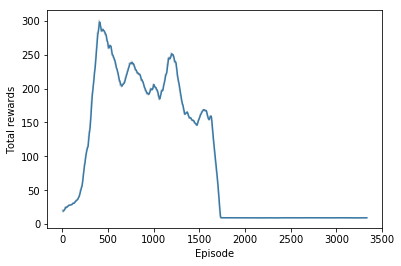

In [38]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

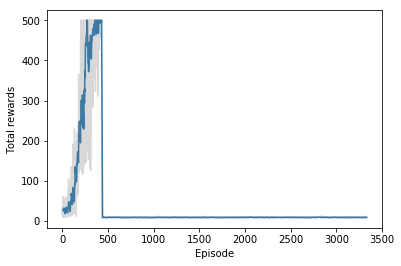

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

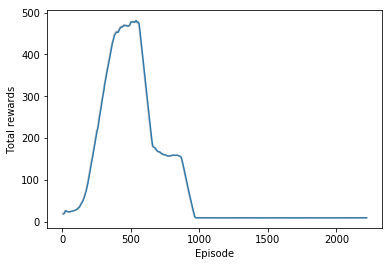

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

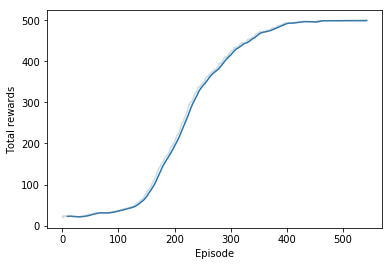

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

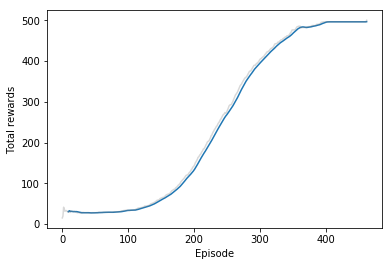

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

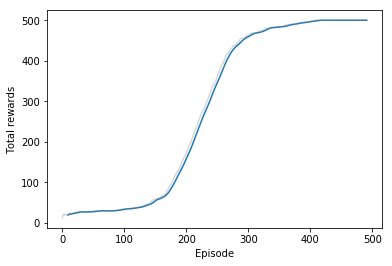

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

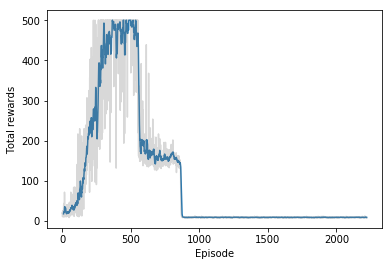

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

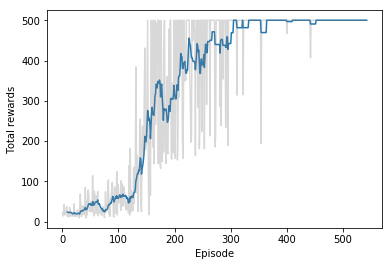

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

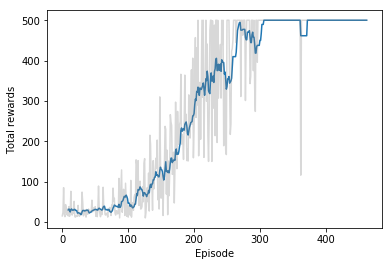

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

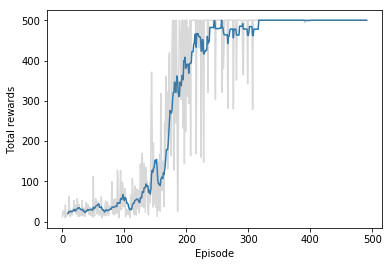

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.